### Import Packages:

In [1]:
# import packages
import modin.pandas as md
import pandas as pd
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as wb
import numpy as np
import matplotlib.pyplot as plt
from functions.functions import *
from copy import deepcopy
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import and Clean Up Data:

In [2]:
# monthly stock file location
file_path = 'data/crsp_monthly_file.csv'

# import and clean data
data = import_clean_data(path=file_path)

# compute volumes, stdevs, correls, and betas
data = compute_price_volume(df=data)
data = compute_mkt_stock_volatilities(df=data)
print('computing rolling stock/market correlations...')
data['COR'] = data.groupby('PERMNO').apply(compute_rolling_correlations)
print('computing stock/market betas...')
data['BETA'] = data.groupby('PERMNO').apply(compute_betas)
data = compute_adjusted_betas(df=data)

# drop any rows for which we don't have a beta or return
data = data.dropna(how='any',subset=['BETA','RET'])

# only keep stocks that meet a certain liquidity requirement
daily_liquidity_req = 50000
data = data[data['ADV'] > daily_liquidity_req]

# select starting date
start_date = '1980-12-31'
data = data[data['date'] > start_date]

# compute quantiles
quantiles = 10
print('computing quantiles...')
data['QTLS'] = data.groupby(['date'])['BETA'].transform(lambda x: pd.qcut(x,quantiles,labels=False)+1)

importing and cleaning data...
computing average daily volumes...
computing market/stock volatilities...
computing rolling stock/market correlations...
computing stock/market betas...
computing adjusted betas...
computing quantiles...


### Reduce Dataset, Compute Holding Periods for Next Month, Merge Holding Periods Back on Return Data:

In [3]:
# just take the top and bottom quantiles, this speeds up future computations
reduced_data = compute_reduced_dataset(df=data,quantiles=quantiles,top_mktcap=False,no_companies_per_quantile=500)

# compute returns on portfolio that holds the stocks for the next month
holding_periods = compute_holding_periods(df=reduced_data)

# also scales quantile portfolio weights so that their Beta relative to the market approximates 1
port, portfolio = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods)

reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
scaling weights according to betas...


### Pivot Returns and Set Up Return Plots:

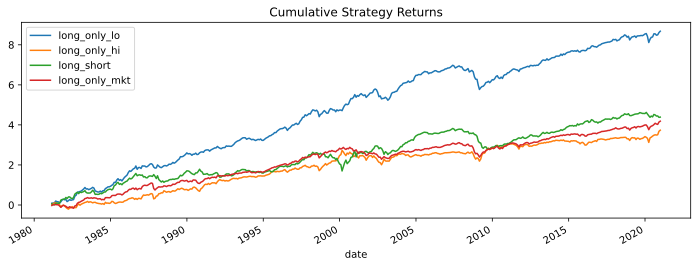

In [4]:
# pivot portfolio returns for plotting
strategy_pivot = port.pivot(index='date', columns='QTLS', values='RET').add_prefix('quantile ').rename(columns={'quantile 1': 'low',f'quantile {quantiles}': 'high'}).fillna(0)

# compute low-beta portfolio less high-beta portfolio returns
strategy_pivot['low-high'] = strategy_pivot.low - strategy_pivot.high

# add value-weighted market returns
mkt = data.drop_duplicates(subset=['date','vwretd']).sort_values(by=['date'])[['date','vwretd']].set_index('date')
mkt['long_only_mkt'] = np.log(1 + mkt).cumsum()
mkt = mkt[mkt.index >= strategy_pivot.index[0]]

# compute strategy cumulative returns
strategy_pivot['long_only_lo'] = np.log(1 + strategy_pivot.low).cumsum()
strategy_pivot['long_only_hi'] = np.log(1 + strategy_pivot.high).cumsum()
strategy_pivot['long_short'] = np.log(1 + (strategy_pivot.low - strategy_pivot.high)).cumsum()


# compute plots for each strategy
plt.figure(figsize=(12,4))
strategy_pivot['long_only_lo'].plot()
strategy_pivot['long_only_hi'].plot()
strategy_pivot['long_short'].plot()
mkt['long_only_mkt'].plot()
plt.title('Cumulative Strategy Returns')
plt.legend()
plt.show()

### Confirm That Long/Short End of Portfolio Maintain Approximate Beta of 1:

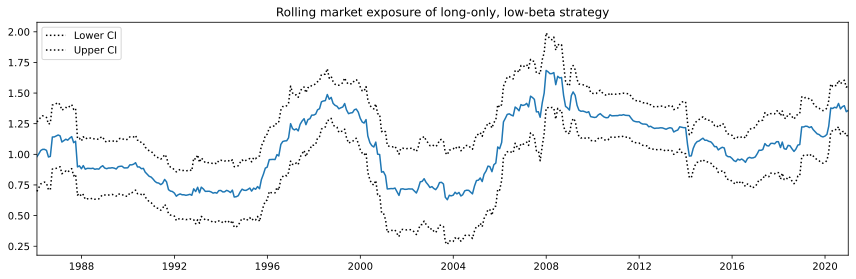

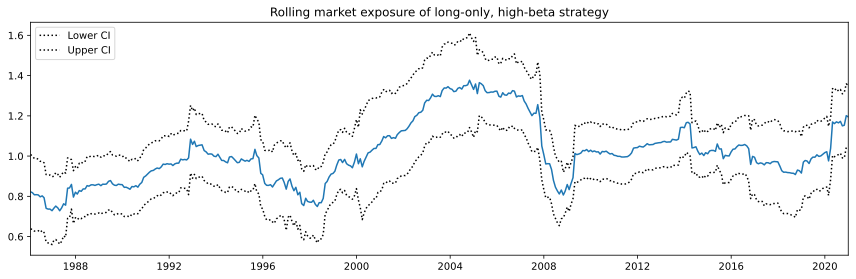

In [5]:
levers = ['low','high']
i = 0
for each in levers:
    # set up rolling regression
    Y = strategy_pivot[each]
    X = sm.add_constant(mkt['vwretd'])
    est = RollingOLS(Y,X,window=60,min_nobs=60,expanding=True).fit()
    leverage_betas = est.params.shift(1)[['vwretd']]

    # plot market exposure coefficients
    est.plot_recursive_coefficient(variables=['vwretd'],figsize=(12,4))
    plt.title(f'Rolling market exposure of long-only, {each}-beta strategy')
    plt.show()

### Pull in Fama French Data:

In [6]:
# issue start date and end date
startdate = strategy_pivot.index[0]
enddate = strategy_pivot.index[-1]

# pull famafrench factors and format
factor_returns = factor_returns = wb.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start=startdate,end=enddate)[0]/100
factor_returns.index = strategy_pivot.index

### Run CAPM Regression:

In [7]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(mkt['vwretd'] - factor_returns['RF'].values)
est = sm.OLS(Y,X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               low-high   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04537
Date:                Wed, 01 Dec 2021   Prob (F-statistic):              0.831
Time:                        19:26:42   Log-Likelihood:                 657.48
No. Observations:                 479   AIC:                            -1311.
Df Residuals:                     477   BIC:                            -1303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.003      2.747      0.0

### Run FF5F Regression:

In [8]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(factor_returns[['Mkt-RF','SMB','HML','RMW','CMA']])
est = sm.OLS(Y,X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               low-high   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     39.76
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           4.16e-34
Time:                        19:26:42   Log-Likelihood:                 741.48
No. Observations:                 479   AIC:                            -1471.
Df Residuals:                     473   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.621      0.5

### Compute and Plot Rolling 5 Year CAPM Alpha:

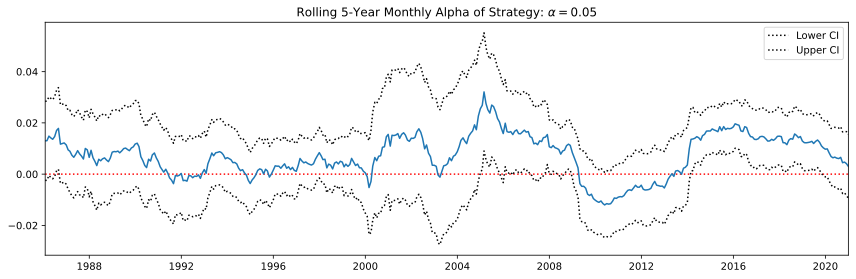

In [9]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(mkt['vwretd'] - factor_returns['RF'].values)
est = RollingOLS(Y,X,window=60,min_nobs=60,expanding=True).fit()
est.plot_recursive_coefficient(variables=['const'],figsize=(12,4))
plt.hlines(0,est.params.dropna(how='all').index[0],est.params.dropna(how='all').index[-1],colors='r',linestyles=':')
plt.title(r'Rolling 5-Year Monthly Alpha of Strategy: $\alpha = 0.05$')
plt.legend()
plt.show()

In [10]:
strategy_pivot

QTLS,low,high,low-high,long_only_lo,long_only_hi,long_short
date,,,,,,
1981-02-27,0.092324,0.032547,0.059776,0.088307,0.032029,0.058058
1981-03-31,0.005782,0.051199,-0.045417,0.094072,0.081960,0.011577
1981-04-30,0.010954,0.005809,0.005144,0.104966,0.087753,0.016708
1981-05-29,0.096197,0.033718,0.062479,0.196813,0.120915,0.077313
1981-06-30,-0.030702,-0.055122,0.024420,0.165630,0.064216,0.101439
...,...,...,...,...,...,...
2020-08-31,-0.000385,0.022781,-0.023166,8.547528,3.505456,4.496604
2020-09-30,-0.065917,-0.012017,-0.053900,8.479338,3.493367,4.441197
2020-10-30,0.018214,0.012235,0.005978,8.497388,3.505528,4.447157


### Robustness Checks

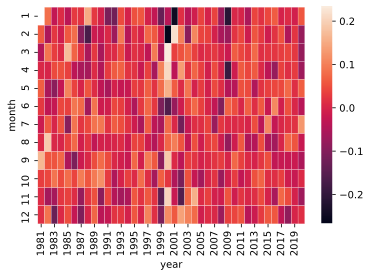

In [11]:
plot_seasonality(strategy_pivot['low-high'], 'low-high')

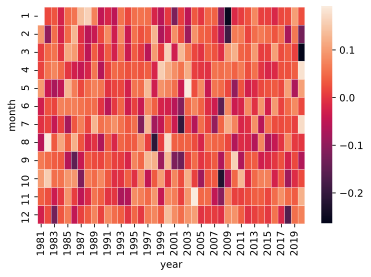

In [12]:
plot_seasonality(strategy_pivot['low'], 'low')